In [1]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN, HDBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

/afs/cern.ch/work/m/mgarciam/private/miniconda/miniconda3/envs/graphgps0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
dic = torch.load("/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_05/showers_df_evaluation/graphs_options9_hdbscan/0_8_3.pt", map_location='cpu')
g = dic["graph"]
betas  = torch.sigmoid(g.ndata["beta"])
X  = g.ndata["coords"]

In [ ]:
15,12

In [70]:
g = dic["graph"]
betas  = torch.sigmoid(g.ndata["beta"])
X  = g.ndata["coords"]
clustering_mode = "clustering_normal"

db = HDBSCAN(min_cluster_size=15, min_samples=10,cluster_selection_epsilon=0.05).fit(X)
labels_hdb = db.labels_ +1
labels_hdb = np.reshape(labels_hdb, (-1))
labels_hdb = torch.Tensor(labels_hdb).long()

labels_pandora = g.ndata["pandora_cluster"].long()
labels_pandora = labels_pandora+1
map_from = list(np.unique(labels_pandora))
cluster_id = map(lambda x: map_from.index(x), labels_pandora)
labels_pandora = torch.Tensor(list(cluster_id)).long()
model_output = torch.cat((g.ndata["coords"], g.ndata["beta"].view(-1,1)), dim=1)
from src.layers.inference_oc import clustering_obtain_labels
labels_clustering = clustering_obtain_labels(
                X, torch.sigmoid(dic["graph"].ndata["beta"].view(-1)), model_output.device, tbeta=0.20, td=0.5
            )
labels = labels_hdb 

particle_ids = torch.unique(g.ndata["particle_number"])
shower_p_unique_hdb = torch.unique(labels)
from src.layers.inference_oc import obtain_intersection_matrix, obtain_union_matrix, match_showers, generate_showers_data_frame
shower_p_unique_hdb, row_ind_hdb, col_ind_hdb, i_m_w_hdb, iou_m = match_showers(
    labels,
    dic,
    particle_ids,
    model_output,
    0,
    0,
    None,
    tracks=True,
    hdbscan=True,
    iou_threshold = 0.1
)
g.ndata["correction"] = torch.ones_like(g.ndata["beta"])
model_output = torch.cat((g.ndata["coords"],g.ndata["beta"].view(-1,1)), dim=1)
particle_ids = torch.unique(g.ndata["particle_number"])

df_event1, number_of_showers_total1, number_of_fake_showers_total = generate_showers_data_frame(
                labels,
                dic,
                shower_p_unique_hdb,
                particle_ids,
                row_ind_hdb,
                col_ind_hdb,
                i_m_w_hdb,
                e_corr=None,
                number_of_showers_total=0,
                step=0,
                number_in_batch=0,
                tracks=True,
                ec_x=None,
                shap_vals=None,
                pred_pos=None,
                save_plots_to_folder=None,
                number_of_fake_showers_total = 0,
            )

(
    shower_p_unique_pandora,
    row_ind_pandora,
    col_ind_pandora,
    i_m_w_pandora,
    iou_m_pandora,
) = match_showers(
    labels_pandora,
    dic,
    particle_ids,
    model_output,
    0,
    0,
    None,
    pandora=True,
    tracks=True,
    iou_threshold = 0.1
)

df_event_pandora, nst, nfs = generate_showers_data_frame(
                    labels_pandora,
                    dic,
                    shower_p_unique_pandora,
                    particle_ids,
                    row_ind_pandora,
                    col_ind_pandora,
                    i_m_w_pandora,
                    pandora=True,
                    tracking=True,
                    number_of_showers_total=0,
                    step=0,      
                    number_in_batch=0,
                    tracks=True,
                    save_plots_to_folder=None,
                    number_of_fake_showers_total = 0,
                )

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt

# iou_matrix = torch.transpose(iou_m[1:, :], 1, 0)
# fig, ax = plt.subplots()
# iou_matrix = iou_matrix.detach().cpu().numpy()
# ax.matshow(iou_matrix, cmap=plt.cm.Blues)
# for i in range(0, iou_matrix.shape[1]):
#     for j in range(0, iou_matrix.shape[0]):
#         c = np.round(iou_matrix[j, i], 1)
#         ax.text(i, j, str(c), va="center", ha="center",fontsize=10,)

In [67]:
df_event1

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,is_track_correct,is_track_in_MC,distance_to_cluster_MC,vertex,ECAL_hits,HCAL_hits,ECAL_hits_true,HCAL_hits_true,delta_MC,true_pos
0,10.413548,9.448417,8.848966,8.621999,-211.0,1.0,8.848966,0.0,0.0,1.0,1.0,1,0.131839,"[0.0, 0.0, 0.0]",258.0,64.0,260.0,69.0,0.125222,"[9.93393611907959, 1.4436520338058472, 2.76681..."
1,6.581086,5.669048,6.201204,5.451390,2112.0,1.0,6.201204,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",1.0,70.0,3.0,66.0,0.124400,"[5.599093914031982, 2.6543753147125244, 2.0080..."
2,29.568899,33.927277,33.689907,33.046284,-321.0,1.0,33.689907,0.0,0.0,1.0,1.0,1,0.121019,"[0.0, 0.0, 0.0]",40.0,229.0,43.0,226.0,0.137170,"[24.457292556762695, -12.416481018066406, 11.0..."
3,7.932523,7.841536,7.789079,7.772223,22.0,1.0,7.789079,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",273.0,0.0,275.0,0.0,0.124400,"[7.099054336547852, 2.362065076828003, 2.63609..."
4,1.583692,1.836915,1.836915,1.836915,13.0,1.0,1.836915,0.0,0.0,1.0,1.0,1,0.216885,"[0.0, 0.0, 0.0]",41.0,21.0,41.0,21.0,0.084711,"[1.1833027601242065, 0.1808282434940338, 1.031..."
5,15.966209,16.616444,16.657690,16.486408,-211.0,1.0,16.657690,0.0,0.0,1.0,1.0,1,0.116118,"[0.0, 0.0, 0.0]",40.0,175.0,41.0,176.0,0.201543,"[13.625042915344238, -3.9357542991638184, 7.33..."
6,1.967549,2.351432,1.910955,1.910955,-2212.0,1.0,1.910955,0.0,0.0,1.0,1.0,1,0.126730,"[0.0, 0.0, 0.0]",52.0,0.0,54.0,4.0,0.146668,"[1.6269090175628662, -0.5263921618461609, 0.25..."
7,10.326580,9.721811,8.886364,8.568538,-2212.0,1.0,8.886364,0.0,0.0,1.0,1.0,1,0.097453,"[0.0, 0.0, 0.0]",321.0,39.0,322.0,46.0,0.137170,"[7.941300868988037, -4.236693859100342, 4.9743..."
8,2.566824,2.745733,2.745733,2.745733,-321.0,1.0,2.745733,0.0,0.0,1.0,1.0,1,0.060514,"[0.0, 0.0, 0.0]",38.0,0.0,38.0,0.0,0.084711,"[1.9661195278167725, 0.1680823117494583, 1.565..."
9,50.149715,48.274807,52.616051,45.646324,130.0,1.0,52.616051,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",1112.0,98.0,1031.0,85.0,0.036657,"[48.294647216796875, 10.60427474975586, 8.3619..."


In [71]:
df_event1[np.isnan(df_event1.pred_showers_E.values)+np.isnan(df_event1.true_showers_E.values)]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,is_track_correct,is_track_in_MC,distance_to_cluster_MC,vertex,ECAL_hits,HCAL_hits,ECAL_hits_true,HCAL_hits_true,delta_MC,true_pos
13,NaN,NaN,0.184061,NaN,NaN,1.0,0.184061,0.0,0.0,0.0,0.0,0,0.0,"[nan, nan, nan]",16.0,0.0,NaN,NaN,NaN,"[nan, nan, nan]"


In [69]:
df_event_pandora[np.isnan(df_event_pandora.pred_showers_E.values)+np.isnan(df_event_pandora.true_showers_E.values)]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pandora_ref_pt,pid,pandora_pid,...,is_track_correct,is_track_in_MC,distance_to_cluster_MC,vertex,ECAL_hits,HCAL_hits,ECAL_hits_true,HCAL_hits_true,delta_MC,true_pos
13,NaN,NaN,0.0,NaN,0.0,0.0,"[7.834444522857666, -0.3125937283039093, 3.003...","[13.260000228881836, -0.5192487835884094, 5.08...",NaN,13.0,...,0.0,1,0.214906,"[nan, nan, nan]",0.0,0.0,NaN,NaN,NaN,"[nan, nan, nan]"


In [42]:
def calculate_delta_MC(y):
    y1 = y
    y_i = y1
    pseudorapidity = -torch.log(torch.tan(y_i.angle[:,0] / 2))
    phi = y_i.angle[:,1]
    x1 = torch.cat((pseudorapidity.view(-1, 1), phi.view(-1, 1)), dim=1)
    distance_matrix = torch.cdist(x1, x1, p=2)
    shape_d = distance_matrix.shape[0]
    values, _ = torch.sort(distance_matrix, dim=1)
    if shape_d>1:
        delta_MC = values[:, 1]
    else:
        delta_MC = torch.ones((shape_d,1)).view(-1)
    return delta_MC
delta_MC = calculate_delta_MC(dic["part_true"])

In [43]:
delta_MC

tensor([0.0434, 0.0587, 0.1432, 0.0483, 0.0026, 0.0483, 0.1344, 0.2384, 0.1344,
        0.2356, 0.1949, 0.0010, 0.0010, 0.0026])

In [44]:
torch.unique(g.ndata['particle_number'])

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14.])

In [153]:
torch.sum(g.ndata['hit_type'][g.ndata['particle_number']==8]==1), torch.sum(g.ndata['hit_type'][g.ndata['particle_number']==8]==2), torch.sum(g.ndata['hit_type'][g.ndata['particle_number']==8]==3)

(tensor(0), tensor(669), tensor(0))

In [168]:

import pandas as pd
import plotly.express as px
from src.logger.plotting_tools import shuffle_truth_colors
from src.layers.inference_oc import clustering_obtain_labels

mask = (g.ndata['particle_number']==1) +(g.ndata['particle_number']==12)#+(g.ndata['particle_number']==1)+(g.ndata['particle_number']==8)

tidx = 1*(labels_hdb[mask].view(-1,1)) # 1*(g.ndata['particle_number'][mask].view(-1,1)) #1*(g.ndata['particle_number'][mask].view(-1,1)) #1*(labels_hdb[mask].view(-1,1))  # 1*(labels_clustering[mask].view(-1,1)) 
#tidx =    1*(g.ndata['hit_link_modified'][mask].view(-1,1))+1
features =   20*g.ndata['e_hits'][mask].view(-1,1)+g.ndata['h'][:,-1][mask].view(-1,1)/20
cellid= g.ndata['particle_number'][mask].view(-1,1)
chi_squared_tracks= g.ndata['chi_squared_tracks'][mask].view(-1,1)
X = g.ndata["coords"][mask] #[mask]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
            "cellid":cellid.view(-1, 1).detach().cpu().numpy(),
            "chi_squared_tracks": chi_squared_tracks.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx", "cellid", "chi_squared_tracks"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_white",
range_color=[0,20],
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [82]:

import pandas as pd
import plotly.express as px
from src.logger.plotting_tools import shuffle_truth_colors
from src.layers.inference_oc import clustering_obtain_labels

mask = (g.ndata['particle_number']==15) +(g.ndata['particle_number']==10)#+(g.ndata['particle_number']==1)+(g.ndata['particle_number']==8)

tidx = 1*(g.ndata['particle_number'][mask].view(-1,1)) #1*(g.ndata['particle_number'][mask].view(-1,1)) #1*(labels_hdb[mask].view(-1,1))  # 1*(labels_clustering[mask].view(-1,1)) 
#tidx =    1*(g.ndata['hit_link_modified'][mask].view(-1,1))+1
features =   20*g.ndata['e_hits'][mask].view(-1,1)+g.ndata['h'][:,-1][mask].view(-1,1)/20
cellid= g.ndata['particle_number'][mask].view(-1,1)
chi_squared_tracks= g.ndata['chi_squared_tracks'][mask].view(-1,1)
X = g.ndata["pos_hits_xyz"][mask] #[mask]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
            "cellid":cellid.view(-1, 1).detach().cpu().numpy(),
            "chi_squared_tracks": chi_squared_tracks.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx", "cellid", "chi_squared_tracks"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_white",
range_color=[0,15],
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [196]:

import pandas as pd
import plotly.express as px
from src.logger.plotting_tools import shuffle_truth_colors
from src.layers.inference_oc import clustering_obtain_labels

mask = (g.ndata['particle_number']==8)+(g.ndata['particle_number']==7)
tidx =  g.ndata['particle_number'][mask].view(-1,1) #1*(labels_clustering[mask].view(-1,1))  #1*(g.ndata['particle_number'][mask].view(-1,1)) #1*(labels_hdb[mask].view(-1,1))  # 1*(labels_clustering[mask].view(-1,1)) 
#tidx =    1*(g.ndata['hit_link_modified'][mask].view(-1,1))+1
features =  torch.sigmoid(g.ndata['beta'][mask].view(-1,1)) #+g.ndata['h'][:,-1][mask].view(-1,1)/20 #20*g.ndata['e_hits'][mask].view(-1,1)+g.ndata['h'][:,-1][mask].view(-1,1)/20
cellid= g.ndata['particle_number'][mask].view(-1,1)
chi_squared_tracks= g.ndata['chi_squared_tracks'][mask].view(-1,1)
X = g.ndata["pos_hits_xyz"][mask] #[mask]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
            "cellid":cellid.view(-1, 1).detach().cpu().numpy(),
            "chi_squared_tracks": chi_squared_tracks.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx", "cellid", "chi_squared_tracks"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_white",
range_color=[0,8],
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [13]:
torch.sum(g.ndata["hit_type"]==4)

tensor(24)

In [11]:
torch.unique(g.ndata["particle_number"][g.ndata["hit_type"]==4])

tensor([ 4.,  5.,  6., 12.])

In [61]:
mask = (g.ndata['particle_number']==4)*(g.ndata["hit_type"]==3)
mask2 = (g.ndata['particle_number']==8)*(g.ndata["hit_type"]==3)
dist_matrix = torch.cdist(g.ndata["pos_hits_xyz"][mask], g.ndata["pos_hits_xyz"][mask2])

In [49]:
torch.sum(g.ndata["pos_hits_xyz"][mask][0]*g.ndata["pos_hits_xyz"][mask][1])/(torch.norm(g.ndata["pos_hits_xyz"][mask][0])*torch.norm(g.ndata["pos_hits_xyz"][mask][1]))

tensor(1.0000)

In [57]:
torch.sum(mask)

tensor(51)

In [58]:
angles = []
for i in range(0,50):
    id = i
    angles.append(torch.sum(g.ndata["pos_hits_xyz"][mask][0]*g.ndata["pos_hits_xyz"][mask][id])/(torch.norm(g.ndata["pos_hits_xyz"][mask][0])*torch.norm(g.ndata["pos_hits_xyz"][mask][id])))

In [59]:
angles

[tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(0.9967),
 tensor(0.9970),
 tensor(0.9943),
 tensor(0.9971),
 tensor(0.9865),
 tensor(0.9864),
 tensor(0.9952),
 tensor(0.9951),
 tensor(0.9980),
 tensor(0.9980)]

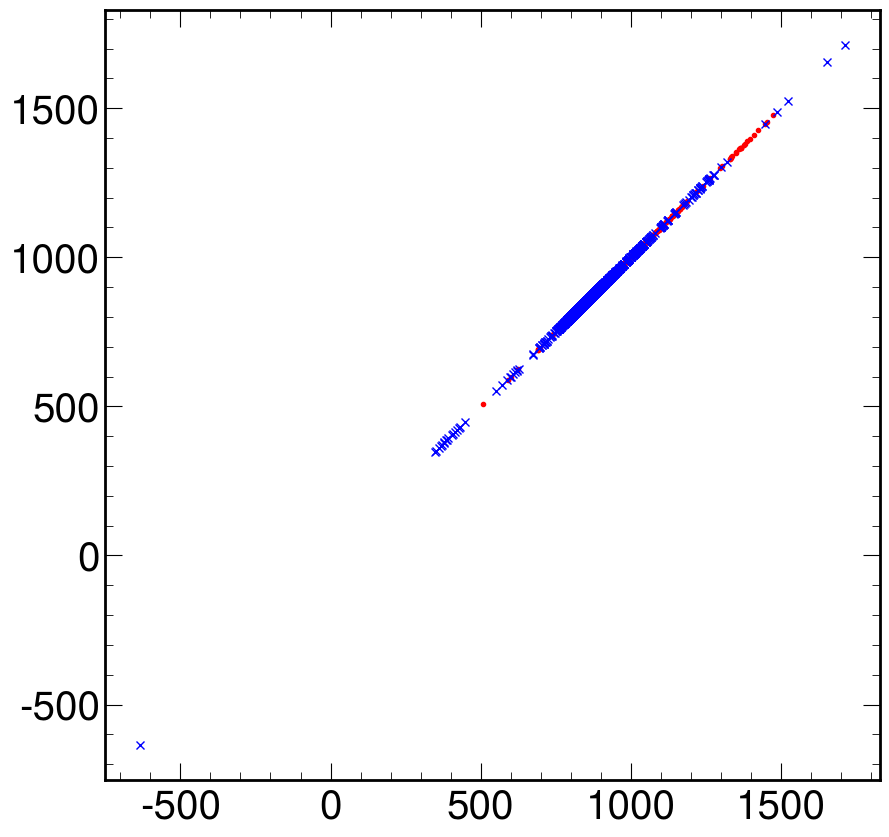

In [31]:
plt.figure()
mask = (g.ndata['particle_number']==4) 
plt.plot(g.ndata["pos_hits_xyz"][mask][:,0],g.ndata["pos_hits_xyz"][mask][:,0],"r.")
mask = (g.ndata['particle_number']==8) 
plt.plot(g.ndata["pos_hits_xyz"][mask][:,0],g.ndata["pos_hits_xyz"][mask][:,0],"bx")

In [85]:
g = dic["graph"]
mask_hit_type_t1 = g.ndata["hit_type"]==2
mask_hit_type_t2 = g.ndata["hit_type"]==1
mask_all = mask_hit_type_t1
# the other error could come from no hits in the ECAL for a cluster
# mean_pos_cluster = scatter_mean(g.ndata["pos_hits_xyz"][mask_all], g.ndata["particle_number"][mask_all].long().view(-1), dim=0)
mean_pos_cluster_all = []
mean_pos_cluster_ecal = []
pos_track = g.ndata["pos_hits_xyz"][mask_hit_type_t2]
particle_track = g.ndata["particle_number"][mask_hit_type_t2]
if len(particle_track)>0:
    for index, i in enumerate(particle_track):
        if i ==0:
            mean_pos_cluster_all.append(torch.zeros((1,3)).view(-1,3))
            mean_pos_cluster_ecal.append(torch.zeros((1,3)).view(-1,3))
        else:
            mask_labels_i = g.ndata["particle_number"] ==i
            mean_pos_cluster = torch.mean(g.ndata["pos_hits_xyz"][mask_labels_i*mask_hit_type_t1], dim=0)
            mean_pos_cluster_all.append(mean_pos_cluster.view(-1,3))
            if len(g.ndata["radial_distance"][mask_labels_i*mask_hit_type_t1])>50:
                index_search_ecal = 50
            else:
                index_search_ecal = len(g.ndata["radial_distance"][mask_labels_i*mask_hit_type_t1])

            index_sort = torch.argsort(g.ndata["radial_distance"][mask_labels_i*mask_hit_type_t1])[0:index_search_ecal]
            distance_from_track = (torch.norm(g.ndata["pos_hits_xyz"][mask_labels_i*mask_hit_type_t1][index_sort]-pos_track[index], dim=1)/1000) < 0.1
            if torch.sum(distance_from_track)==0:
                mean_pos_cluster_ecal.append(torch.zeros((1,3)).view(-1,3))
            else:
                mean_cl = torch.sum(g.ndata["pos_hits_xyz"][mask_labels_i*mask_hit_type_t1][index_sort][distance_from_track]*g.ndata["e_hits"][mask_labels_i*mask_hit_type_t1][index_sort][distance_from_track], dim=0)/torch.sum(g.ndata["e_hits"][mask_labels_i*mask_hit_type_t1][index_sort][distance_from_track])
                mean_pos_cluster_ecal.append(mean_cl.view(-1,3))
    mean_pos_cluster_all = torch.cat(mean_pos_cluster_all, dim=0)
    mean_pos_cluster_ecal = torch.cat(mean_pos_cluster_ecal, dim=0)
    angles = torch.sum(mean_pos_cluster_ecal*pos_track,dim=1)/(torch.norm(mean_pos_cluster_ecal, dim=1)*torch.norm(pos_track, dim=1))
    angles[torch.isnan(angles)]=0
    
    # if  torch.sum(g.ndata["particle_number"] == 0)==0:
    #     #then index 1 is at 0 
    #     mean_pos_cluster = mean_pos_cluster[1:,:]
    #     particle_track = particle_track-1
    # if mean_pos_cluster.shape[0]> torch.max(particle_track):
    #     distance_track_cluster = torch.norm(mean_pos_cluster[particle_track.long()]-pos_track,dim=1)/1000
    distance_track_cluster = torch.norm(mean_pos_cluster_all-pos_track,dim=1)/1000
    print("distance_track_cluster",distance_track_cluster)
    print("angles", angles)

distance_track_cluster tensor([0.1959, 0.1142, 0.2129, 0.0852, 0.0865, 0.1105, 0.1004, 0.1033, 6.1090])
angles tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000])


In [86]:
particle_track

tensor([ 8.,  6.,  4., 15.,  2., 12.,  5.,  3.,  9.])

In [46]:
bad_tracks = ((distance_track_cluster>0.21)+(angles<0.9998))*(pid.view(-1)!=13)
bad_tracks

tensor([False, False,  True, False, False, False, False, False, False])

In [44]:
pid = dic["part_true"].pid[particle_track.long()-1]
pid[particle_track.long()==0]=0
pid = torch.abs(pid)

In [46]:
torch.max(betas[g.ndata['particle_number']==4]),torch.max(betas[g.ndata['particle_number']==1])

(tensor(0.6793), tensor(0.9653))

In [147]:

import pandas as pd
import plotly.express as px
from src.logger.plotting_tools import shuffle_truth_colors

mask =( g.ndata['particle_number']==12)
tidx =  1*( g.ndata['hit_type'][mask].view(-1,1)) #1*(g.ndata['hit_type'][mask].view(-1,1)) #1*(labels_hdb[mask].view(-1,1))  #
#tidx =    1*(g.ndata['hit_link_modified'][mask].view(-1,1))+1
features =   g.ndata['e_hits'][mask].view(-1,1)+g.ndata['h'][:,-1][mask].view(-1,1)/20
cellid= g.ndata['particle_number'][mask].view(-1,1)
chi_squared_tracks= g.ndata['chi_squared_tracks'][mask].view(-1,1)
X = g.ndata["pos_hits_xyz"][mask] #[mask]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
            "cellid":cellid.view(-1, 1).detach().cpu().numpy(),
            "chi_squared_tracks": chi_squared_tracks.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx", "cellid", "chi_squared_tracks"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_white",
range_color=[0,4],
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [149]:
torch.sum(g.ndata['hit_type'][g.ndata['particle_number']==12]==3)

tensor(2)

In [8]:
object_index = g.ndata["particle_number"]
ecal_hits = scatter_add(
1 * (g.ndata["hit_type"] == 2), object_index.long()
)
hcal_hits = scatter_add(
    1 * (g.ndata["hit_type"] == 3), object_index.long()
)
print(hcal_hits)
mask = (hcal_hits<10).bool()*(ecal_hits>0).bool()*(hcal_hits>0).bool()
hcal_hits[mask]=ecal_hits[mask].long()
track_hits = scatter_add(
    1 * (g.ndata["hit_type"] == 1), object_index.long()
)*5
muon_hits = scatter_add(
    1 * (g.ndata["hit_type"] == 4), object_index.long()
)
number_classes = 1*(ecal_hits>0)+1*(hcal_hits>0)+1*(track_hits>0)+1*(muon_hits>0)
weight_ecal_per_object = 1.0 * torch.ones_like(ecal_hits)
weight_hcal_per_object = 1.0 *  torch.ones_like(ecal_hits)
weight_track_per_object = 1.0 * torch.ones_like(ecal_hits)
weight_muon_per_object = 1.0 *  torch.ones_like(ecal_hits)
weight_ecal_per_object = (ecal_hits + hcal_hits+track_hits+muon_hits) / (
    number_classes * ecal_hits
)
weight_hcal_per_object = (ecal_hits + hcal_hits+track_hits+muon_hits) / (
    number_classes* hcal_hits
)
weight_track_per_object = (ecal_hits + hcal_hits+track_hits+muon_hits) / (
    number_classes* track_hits
)
weight_muon_per_object = (ecal_hits + hcal_hits+track_hits+muon_hits) / (
    number_classes* muon_hits
)

tensor([  0,  34,  40,  22,   0,  83,   0,   8,  45,   0, 126,   4,   2,  23,
          0])


In [9]:
hcal_hits

tensor([  0,  34,  40,  22,   0,  83,   0,  52,  45,   0, 126,   7, 674,  23,
          0])

In [10]:
ecal_hits

tensor([  1,   0,   0,  41,  34, 279, 105,  52,  46, 242, 176,   7, 674,   0,
          9])

In [83]:
# all_weights = torch.cat((weight_ecal_per_object.view(-1,1), weight_hcal_per_object.view(-1,1), weight_muon_per_object.view(-1,1)), dim=1)
# all_weights[all_weights>1000] =0
# torch.max(all_weights, dim=1)[0]*5

tensor([  5.8333,   5.1082,   3.9855,  13.1754,   6.0569,  36.6667,  11.1652,
         12.1429,   5.0000,  14.5312,  52.1296, 294.5833,   5.0000])

In [84]:
# weight_track_per_object[weight_track_per_object>70]=70

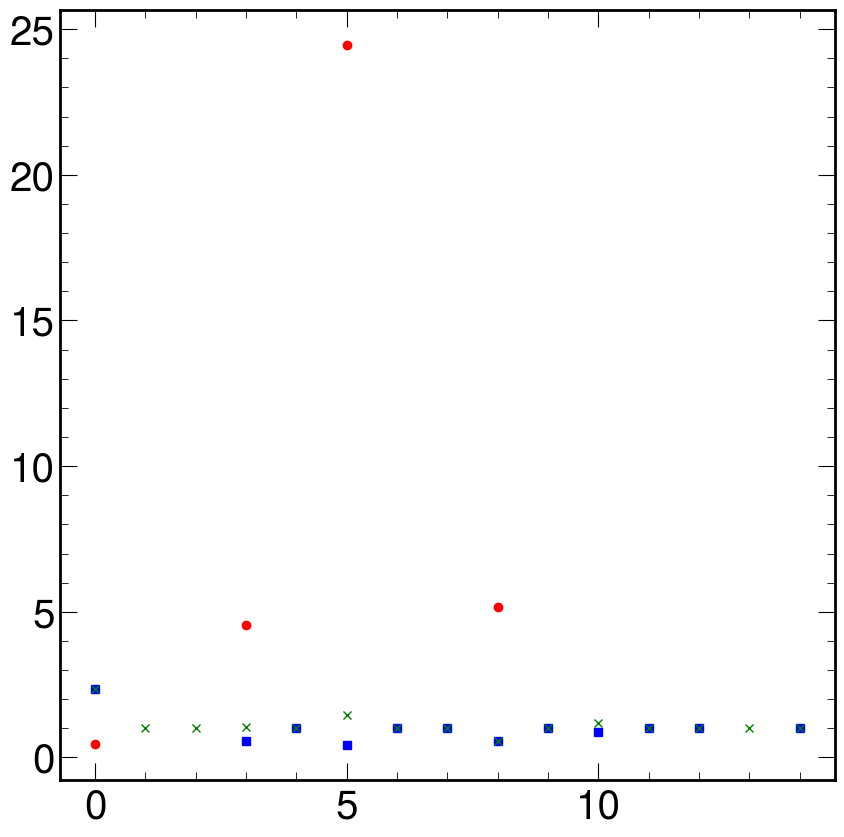

In [153]:
plt.plot(weight_track_per_object, 'ro')
plt.plot(weight_ecal_per_object, 'bs')
plt.plot(weight_hcal_per_object, 'gx')

In [54]:
betas  = torch.sigmoid(g.ndata["beta"])
X  = g.ndata["coords"]
clustering_mode = "clustering_normal"

db = HDBSCAN(min_cluster_size=8, min_samples=8, cluster_selection_epsilon=0.10).fit(X)
labels_hdb = db.labels_ +1
labels_hdb = np.reshape(labels_hdb, (-1))
labels_hdb = torch.Tensor(labels_hdb).long()

labels_pandora = g.ndata["pandora_cluster"].long()
labels_pandora = labels_pandora+1
map_from = list(np.unique(labels_pandora))
cluster_id = map(lambda x: map_from.index(x), labels_pandora)
labels_pandora = torch.Tensor(list(cluster_id)).long()
labels = labels_hdb 
model_output = torch.cat((g.ndata["coords"], g.ndata["beta"].view(-1,1)), dim=1)
particle_ids = torch.unique(g.ndata["particle_number"])
shower_p_unique_hdb = torch.unique(labels)
from src.layers.inference_oc import obtain_intersection_matrix, obtain_union_matrix, match_showers, generate_showers_data_frame
shower_p_unique_hdb, row_ind_hdb, col_ind_hdb, i_m_w_hdb, iou_m = match_showers(
    labels_hdb,
    dic,
    particle_ids,
    model_output,
    0,
    0,
    None,
    tracks=True,
    hdbscan=True,
)
labels = labels_hdb
g.ndata["correction"] = torch.ones_like(g.ndata["beta"])
model_output = torch.cat((g.ndata["coords"],g.ndata["beta"].view(-1,1)), dim=1)
particle_ids = torch.unique(g.ndata["particle_number"])

df_event1, number_of_showers_total1, number_of_fake_showers_total = generate_showers_data_frame(
                labels_hdb,
                dic,
                shower_p_unique_hdb,
                particle_ids,
                row_ind_hdb,
                col_ind_hdb,
                i_m_w_hdb,
                e_corr=None,
                number_of_showers_total=0,
                step=0,
                number_in_batch=0,
                tracks=True,
                ec_x=None,
                shap_vals=None,
                pred_pos=None,
                save_plots_to_folder=None,
                number_of_fake_showers_total = 0,
            )




In [57]:
df_event1

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,is_track_correct,is_track_in_MC,distance_to_cluster_MC,vertex,ECAL_hits,HCAL_hits,true_pos
0,2.959113,2.254679,2.254679,2.254679,130.0,1.0,2.254679,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",0.0,34.0,"[-2.7014172077178955, -0.06968846917152405, -1..."
1,4.480514,4.448130,4.448130,4.448130,2112.0,1.0,4.448130,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",0.0,40.0,"[-4.1486101150512695, -0.8835501074790955, -1...."
2,1.803656,2.575016,2.575016,2.575016,-321.0,1.0,2.575016,0.0,0.0,1.0,1.0,1,0.144769,"[0.0, 0.0, 0.0]",41.0,22.0,"[1.0888344049453735, 1.1774013042449951, -0.66..."
3,0.789738,0.590055,0.622329,0.590055,-11.0,1.0,0.622329,0.0,0.0,1.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",36.0,0.0,"[0.49526169896125793, -0.5848667621612549, 0.1..."
4,12.855723,11.794163,11.811718,11.794163,-321.0,1.0,11.811718,0.0,0.0,1.0,1.0,1,0.149622,"[0.0, 0.0, 0.0]",281.0,83.0,"[12.838484764099121, 0.13805001974105835, 0.42..."
5,2.454201,2.662861,2.637961,2.630587,22.0,1.0,2.637961,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",104.0,0.0,"[-2.2892608642578125, 0.3683021664619446, 0.80..."
6,4.328761,2.469327,2.451771,2.451771,2112.0,1.0,2.451771,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",50.0,8.0,"[3.7411582469940186, 1.8668261766433716, -0.61..."
7,36.765247,2.071350,2.071350,2.071350,-13.0,1.0,2.071350,0.0,0.0,1.0,1.0,1,0.099448,"[0.0, 0.0, 0.0]",46.0,45.0,"[-27.897886276245117, -23.884973526000977, 1.6..."
8,6.754602,6.353566,6.353566,6.353566,22.0,1.0,6.353566,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",242.0,0.0,"[1.1926231384277344, 6.074285507202148, 2.7028..."
9,18.382393,15.309785,15.309785,15.309785,2112.0,1.0,15.309785,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",176.0,126.0,"[-6.112584114074707, 16.120162963867188, -6.30..."


In [60]:
df_event_pandora

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pandora_ref_pt,pid,pandora_pid,step,number_batch,is_track_in_cluster,is_track_correct,is_track_in_MC,distance_to_cluster_MC,vertex,ECAL_hits,HCAL_hits,true_pos
0,2.959113,2.254679,1.994793,1.952404,3.507608,3.507608,"[-3.2940192222595215, -0.11610008776187897, -1...","[-2781.08837890625, -75.93334197998047, -1062....",130.0,2112.000000,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",0.0,30.0,"[-2.7014172077178955, -0.06968846917152405, -1..."
1,4.480514,4.448130,3.686804,3.686804,3.649162,3.649162,"[-3.4731452465057373, -0.7917192578315735, -0....","[-2643.469482421875, -529.8468017578125, -714....",2112.0,2112.000000,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",0.0,31.0,"[-4.1486101150512695, -0.8835501074790955, -1...."
2,1.803656,2.575016,2.403778,2.403778,3.144617,1.734917,"[1.0845459699630737, 1.174285650253296, -0.659...","[8.986544609069824, 9.765929222106934, -5.4741...",-321.0,-211.000000,0.0,0.0,1.0,1.0,1,0.144769,"[0.0, 0.0, 0.0]",41.0,20.0,"[1.0888344049453735, 1.1774013042449951, -0.66..."
3,0.789738,0.590055,0.584238,0.584238,0.632214,0.658416,"[-0.15765893459320068, -0.5997195839881897, 0....","[-647.3375244140625, -2064.435302734375, 649.2...",-11.0,2056.088135,0.0,0.0,1.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",33.0,0.0,"[0.49526169896125793, -0.5848667621612549, 0.1..."
4,12.855723,11.794163,10.692489,10.692489,12.466373,12.865006,"[12.85643196105957, 0.13560904562473297, 0.429...","[13.260008811950684, 0.148385152220726, 0.4344...",-321.0,-211.000000,0.0,0.0,1.0,1.0,1,0.149622,"[0.0, 0.0, 0.0]",217.0,74.0,"[12.838484764099121, 0.13805001974105835, 0.42..."
5,2.454201,2.662861,2.584332,2.584332,2.630253,2.630253,"[-2.453216314315796, 0.39604952931404114, 0.86...","[-2202.94140625, 356.2734680175781, 774.066894...",22.0,22.000000,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",92.0,0.0,"[-2.2892608642578125, 0.3683021664619446, 0.80..."
6,4.328761,2.469327,2.247339,2.247339,2.634550,2.634550,"[2.322965383529663, 1.1981992721557617, -0.330...","[2148.69775390625, 1000.1524047851562, -367.97...",2112.0,2112.000000,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",40.0,6.0,"[3.7411582469940186, 1.8668261766433716, -0.61..."
7,36.765247,2.071350,1.875595,1.875595,3.871263,36.571686,"[-27.75074005126953, -23.759647369384766, 1.68...","[-10.105589866638184, -8.646885871887207, 0.62...",-13.0,-13.000000,0.0,0.0,0.0,0.0,1,0.099448,"[0.0, 0.0, 0.0]",18.0,45.0,"[-27.897886276245117, -23.884973526000977, 1.6..."
8,6.754602,6.353566,6.184831,6.184831,6.294727,6.294727,"[1.1128531694412231, 5.660397529602051, 2.5189...","[434.8413391113281, 2213.125732421875, 985.296...",22.0,22.000000,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",198.0,0.0,"[1.1926231384277344, 6.074285507202148, 2.7028..."
9,18.382393,15.309785,13.967619,13.967619,15.250441,15.250441,"[-5.067662715911865, 13.400702476501465, -5.22...","[-926.2186889648438, 2426.22412109375, -940.09...",2112.0,2112.000000,0.0,0.0,0.0,0.0,0,0.000000,"[0.0, 0.0, 0.0]",144.0,117.0,"[-6.112584114074707, 16.120162963867188, -6.30..."


In [59]:
mask = ~np.isnan(df_event_pandora["reco_showers_E"])
eff = np.sum(~np.isnan(df_event_pandora["pred_showers_E"][mask].values)) / len(
    df_event_pandora["pred_showers_E"][mask].values
)
eff

0.9285714285714286

In [122]:
dic["graph"].ndata["pandora_pfo"][dic["graph"].ndata["particle_number"]==8]

tensor([11., 11., 11., -1., 11., 11., 11., 11., 11., 11., -1., 11., -1.,  7.,
        -1., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11.,  7.])

In [123]:
dic["graph"].ndata["particle_number"][dic["graph"].ndata["pandora_pfo"]==11]

tensor([8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
        8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
        8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 7., 7., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [70]:
10,7,6, 26, 28

(4, 7, 11, 10)

In [71]:
# dic["graph"].ndata["particle_number"][dic["graph"].ndata["pandora_pfo"]==5]

In [27]:
np.nansum(df_event_pandora.pandora_calibrated_pfo)/np.nansum(df_event_pandora.true_showers_E)

1.0287228

In [28]:
np.nansum(df_event1.pred_showers_E)/np.nansum(df_event1.reco_showers_E)

0.96292645

<Axes: ylabel='Count'>

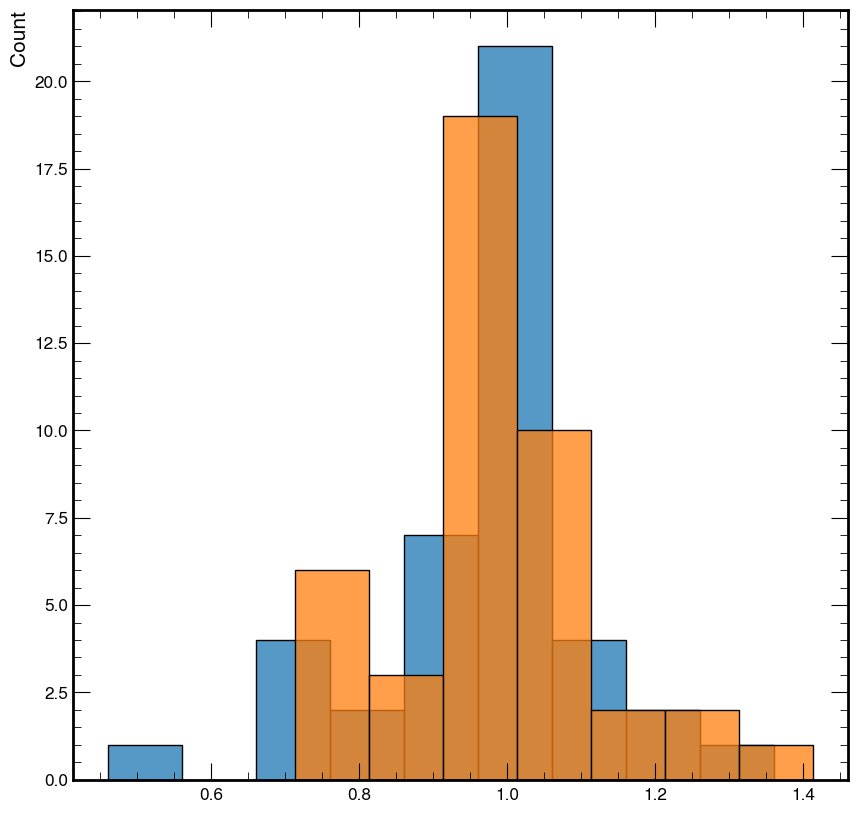

In [18]:
sl_p = df_event_pandora[~np.isnan(df_event_pandora.e_pred_and_truth)]
sl = df_event[~np.isnan(df_event.e_pred_and_truth)]
import seaborn as sns
sns.histplot(sl_p.pred_showers_E/sl_p.reco_showers_E,binwidth=0.1)
sns.histplot(sl.pred_showers_E/sl.reco_showers_E, binwidth=0.1)

In [79]:
np.nansum(df_event1.pred_showers_E)/np.nansum(df_event1.reco_showers_E)

0.96127325

In [80]:
np.nansum(df_event_pandora.pred_showers_E)/np.nansum(df_event_pandora.reco_showers_E)

0.98057485

In [6]:
# weights = torch.ones_like(dic["graph"].ndata["particle_number"])
# for i in torch.unique(dic["graph"].ndata["particle_number"]):   
#     mask  = dic["graph"].ndata["particle_number"] == i
#     mask2 = mask* (dic["graph"].ndata["hit_type"]==1)
#     mask3 = mask* (dic["graph"].ndata["hit_type"]==0)
#     a = dic["graph"].ndata["hit_type"][mask]
#     total_hits = len(a)
#     n_vtx_hits = torch.sum(a)
#     n_dch = total_hits-torch.sum(a)
#     print(i, total_hits,n_vtx_hits,n_dch)
#     if n_dch>0 and n_vtx_hits>0:
#             weights[mask3] = total_hits/(2*n_dch)
#             weights[mask2] = total_hits/(2*n_vtx_hits)
    

In [13]:
dic["part_true"].pid

tensor([[   22.],
        [  130.],
        [  130.],
        [  -11.],
        [   22.],
        [ 2112.],
        [   22.],
        [  130.],
        [ 2112.],
        [  130.],
        [ -211.],
        [ -211.],
        [  130.],
        [ 2112.],
        [   11.],
        [ 2112.],
        [   11.],
        [ -211.],
        [ 2112.],
        [  211.],
        [   22.],
        [   11.],
        [   22.],
        [  -11.],
        [   22.],
        [ 2212.],
        [  130.],
        [ 2112.],
        [ 2212.],
        [ 2112.],
        [ 2112.],
        [-2212.],
        [-2212.],
        [ -211.],
        [ 2112.],
        [ -211.],
        [   22.],
        [   22.],
        [   22.],
        [   22.]])

In [27]:
labels[labels==11]=0

In [81]:
dic["graph"].ndata['particle_number'][dic["graph"].ndata['particle_number']==7]=15

In [84]:
dic["graph"].ndata['particle_number'][dic["graph"].ndata['particle_number']==3]=10

In [130]:
dic["part_true"].E

tensor([[2.1808e+01],
        [3.2622e+01],
        [1.0811e+00],
        [4.5706e+01],
        [2.0874e+00],
        [9.2428e+00],
        [2.1900e+01],
        [1.5027e+00],
        [1.8626e+01],
        [5.8944e+00],
        [6.7888e-01],
        [3.9222e+01],
        [1.1037e+00],
        [4.8915e+00],
        [4.5490e-02]])

In [128]:
pp = [8,1]
mask = (dic["graph"].ndata['particle_number'].view(-1) ==1)
# mask =  (labels == 12)+(labels == 17)+(labels == 18) +(labels == 9) 
for i in pp:
    mask = mask +  (dic["graph"].ndata['particle_number'].view(-1) ==i)
tidx = dic["graph"].ndata['particle_number'][mask].view(-1,1) #1*(dic["graph"].ndata['particle_number'][mask].view(-1,1)) #(labels.view(-1,1))
features =  dic["graph"].ndata['e_hits'][mask]#torch.sigmoid(dic["graph"].ndata["beta"][mask])
X =dic["graph"].ndata["pos_hits_xyz"][mask] # dic["graph"].ndata["pos_hits_xyz"] #dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx,
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_white",
range_color=[0,12],
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [187]:
dic["part_true"].pid

tensor([[  211.],
        [  -11.],
        [  130.],
        [  -11.],
        [  130.],
        [   22.],
        [   22.],
        [ 2112.],
        [-2212.],
        [   22.],
        [   22.],
        [   22.]])

In [64]:
from src.logger.plotting_tools import shuffle_truth_colors
pp = []
mask =  (dic["graph"].ndata['particle_number'].view(-1)!=-1) #+(dic["graph"].ndata['pandora_pfo'].view(-1)==33)
for i in pp:
    mask = mask +  (dic["graph"].ndata['particle_number'].view(-1) ==i)
#mask =(dic["graph"].ndata['particle_number'].view(-1) !=-1) #+(dic["graph"].ndata['particle_number'].view(-1) ==25)   + (dic["graph"].ndata['particle_number'].view(-1) ==20)+ (dic["graph"].ndata['particle_number'].view(-1) ==12)+ (dic["graph"].ndata['particle_number'].view(-1) ==15)
tidx =  dic["graph"].ndata['particle_number'].view(-1,1)[mask]#1*(dic["graph"].ndata['particle_number'].view(-1,1)[mask])# +1*(dic["graph"].ndata['particle_number_nomap'].view(-1,1)[mask]==189)#(labels_pandora.view(-1,1))
features = torch.sigmoid(dic["graph"].ndata["beta"][mask]).view(-1,1)
X =dic["graph"].ndata["pos_hits_xyz"][mask]#dic["graph"].ndata["pos_hits_xyz"][mask] # dic["graph"].ndata["pos_hits_xyz"] #dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [186]:
dic

{'graph': Graph(num_nodes=2133, num_edges=0,
       ndata_schemes={'h': Scheme(shape=(9,), dtype=torch.float32), 'pos_hits_xyz': Scheme(shape=(3,), dtype=torch.float32), 'pos_pxpypz': Scheme(shape=(3,), dtype=torch.float32), 'radial_distance': Scheme(shape=(), dtype=torch.float32), 'radial_distance_exp': Scheme(shape=(), dtype=torch.float32), 'hit_type': Scheme(shape=(), dtype=torch.int64), 'e_hits': Scheme(shape=(1,), dtype=torch.float32), 'chi_squared_tracks': Scheme(shape=(), dtype=torch.float32), 'particle_number': Scheme(shape=(), dtype=torch.float32), 'hit_link_modified': Scheme(shape=(), dtype=torch.float32), 'particle_number_nomap': Scheme(shape=(), dtype=torch.float32), 'pandora_cluster': Scheme(shape=(), dtype=torch.float32), 'pandora_pfo': Scheme(shape=(), dtype=torch.float32), 'pandora_cluster_energy': Scheme(shape=(), dtype=torch.float32), 'pandora_pfo_energy': Scheme(shape=(), dtype=torch.float32), 'pos_pxpypz_at_vertex': Scheme(shape=(3,), dtype=torch.float32), 'final_cl

In [72]:
torch.sum(dic["graph"].ndata['hit_type'][mask]==2),torch.sum(dic["graph"].ndata['hit_type'][mask]==3)

(tensor(58), tensor(193))

In [78]:
ecal_hits = scatter_add(1*(dic["graph"].ndata['hit_type']==2), dic["graph"].ndata['particle_number'].view(-1).long())
hcal_hits = scatter_add(1*(dic["graph"].ndata['hit_type']==3), dic["graph"].ndata['particle_number'].view(-1).long())

In [82]:
weights = torch.ones_like(dic["graph"].ndata['hit_type'])

In [93]:
print(ecal_hits)
print(hcal_hits)
weight_ecal_per_object = 1.0*ecal_hits.clone()+1
weight_hcal_per_object = 1.0*ecal_hits.clone()+1
mask =(ecal_hits>2)*(hcal_hits>2)
weight_ecal_per_object[mask] = (ecal_hits+hcal_hits)[mask]/(2*ecal_hits)[mask]
weight_hcal_per_object[mask] = (ecal_hits+hcal_hits)[mask]/(2*hcal_hits)[mask]
print(weight_ecal_per_object)
print(weight_hcal_per_object)


tensor([  0,  58, 445,   0,   0,  85, 138,  77,  36,  41])
tensor([  0, 193,  78,   4, 109,   0,  58,   1,   0,   0])
tensor([ 1.0000,  2.1638,  0.5876,  1.0000,  1.0000, 86.0000,  0.7101, 78.0000,
        37.0000, 42.0000])
tensor([ 1.0000,  0.6503,  3.3526,  1.0000,  1.0000, 86.0000,  1.6897, 78.0000,
        37.0000, 42.0000])


In [92]:
2.1638*58+0.6503*193

251.00830000000002

In [11]:
dic["part_true"][:,5]


tensor([13.0880,  1.7113,  1.8285,  0.1050,  2.1278,  0.5404,  1.0237,  3.4199,
         1.0623,  0.6576,  0.9063,  0.2535,  0.3852,  0.8060,  8.1772,  5.2689,
         0.1015,  0.0384,  0.7845,  0.1765,  0.2769])

In [26]:
parents = dic["part_true"][:,-2]
print(parents)
particle_ids =  dic["part_true"][:, 4]
change_pairs = []
for indx, i in enumerate(parents):
    if torch.sum(particle_ids == i) > 0:
        change_pairs.append([parents[indx], particle_ids[indx]])
print(change_pairs)



tensor([ 24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  61.,  61.,  63.,
         65.,  66.,  66.,  68.,  69.,  70.,  72.,  77.,  80.,  67.,  67.,  67.,
        178.])
[[tensor(67.), tensor(176.)], [tensor(67.), tensor(177.)], [tensor(67.), tensor(178.)], [tensor(178.), tensor(179.)]]


In [25]:
particle_ids

tensor([ 62.,  64.,  67.,  71.,  73.,  75.,  78.,  79.,  81.,  84.,  85.,  86.,
         88.,  90.,  91.,  93.,  95.,  96.,  99., 105., 107., 176., 177., 178.,
        179.])

In [107]:
a = np.exp(np.arange(np.log(0.001), np.log(80), 0.5))

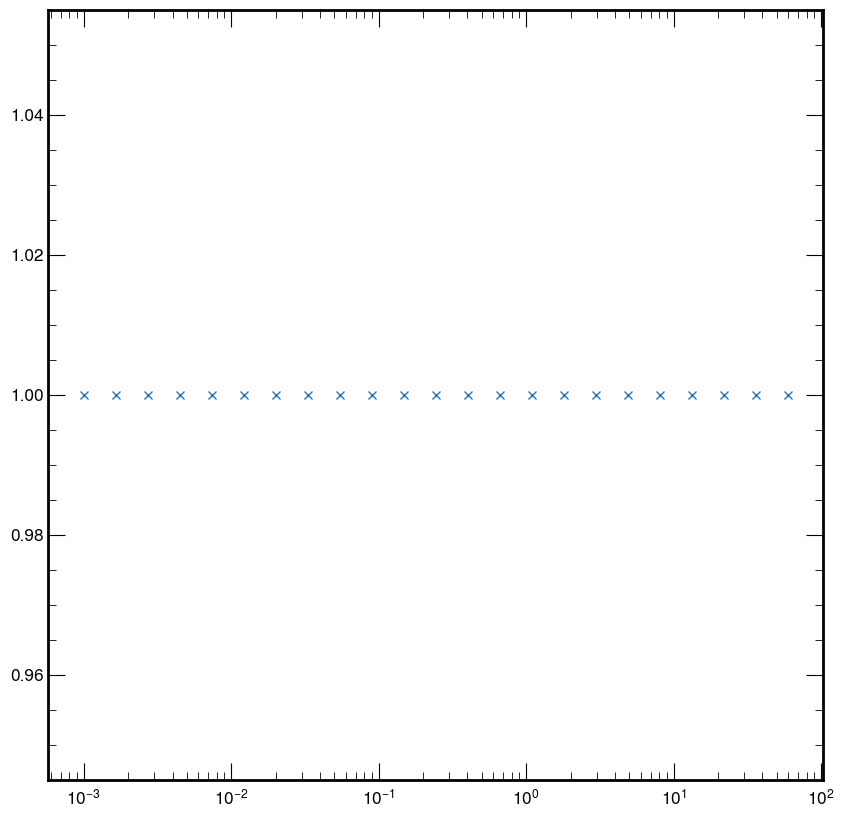

In [109]:
plt.plot(a,np.ones(len(a)),'x')
plt.xscale("log")

In [64]:
print(dic["part_true"][:,3])
print(dic["part_true"][:,4])
print(dic["part_true"][:,5])
print(dic["part_true"][:,6])

tensor([ 1.4387, 16.2788,  8.1231,  2.3531,  1.8258, 36.4957, 40.6092, 11.0805])
tensor([ 1.4319, 16.2788,  8.1231,  2.3531,  1.8258, 36.4836, 40.6092, 11.0805])
tensor([1.3957e-01, 1.2678e-03, 2.2820e-03, 1.8757e-04, 3.8206e-04, 9.3962e-01,
        5.0583e-03, 3.1222e-03])
tensor([ 211.,   22.,  -11.,   22., -211., 2112., -211.,   22.])


In [65]:
dic["graph"].ndata['particle_number']

tensor([7., 3., 5.,  ..., 7., 7., 1.])

In [21]:
from src.logger.plotting_tools import shuffle_truth_colors
mask =(dic["graph"].ndata['particle_number'].view(-1) !=-1) #   + (dic["graph"].ndata['particle_number'].view(-1) ==6 ) 
tidx =  1*(dic["graph"].ndata['particle_number'].view(-1,1)[mask])#(labels_pandora.view(-1,1))
features = torch.sigmoid((dic["graph"].ndata["beta"])[mask])
X =dic["graph"].ndata["pos_hits_xyz"][mask] # dic["graph"].ndata["pos_hits_xyz"] #dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [27]:
torch.exp(-1*torch.Tensor([5])),torch.exp(-1*torch.Tensor([10]))

(tensor([0.0067]), tensor([4.5400e-05]))

In [21]:
from src.logger.plotting_tools import shuffle_truth_colors
mask =(dic["graph"].ndata['particle_number'].view(-1) !=-1) #   + (dic["graph"].ndata['particle_number'].view(-1) ==6 ) 
tidx =  labels_pandora.view(-1,1)[mask]#(labels_pandora.view(-1,1))
features = (dic["graph"].ndata["e_hits"])[mask]
X =dic["graph"].ndata["pos_hits_xyz"][mask] # dic["graph"].ndata["pos_hits_xyz"] #dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [97]:
freq_count_particles[number_of_particles_event] = freq_count_particles[number_of_particles_event]+1
freq_count_energy = freq_count_energy + torch.histogram(energy_particles,energy_event)[0]

In [106]:
from torch_scatter import scatter_max, scatter_add, scatter_mean
cluster_space_coords = g.ndata["pos_hits_xyz"]
object_index = g.ndata["particle_number"].view(-1)
x_alpha_sum = scatter_mean(
    cluster_space_coords,
    object_index.long(),dim=0
) 
nVs = x_alpha_sum[1:] / torch.norm(x_alpha_sum[1:], p=2, dim=-1, keepdim=True)
# compute cosine of the angles using dot product
cos_ij = torch.einsum('ij,pj->ip', nVs, nVs)
min_cos_per_particle = torch.min(torch.abs(cos_ij), dim=0)[0]
freq_count_angle = freq_count_angle + torch.histogram(min_cos_per_particle,angle_distribution)[0]

In [109]:
freq_count_angle

tensor([0., 2., 1., 0., 1., 1., 1., 0., 0., 0.])

tensor([[ 22.3746,   4.2995,  -4.4514],
        [ 22.9379,  24.1192, -11.1488],
        [ 21.6913,  -6.8498, -43.0122],
        [ 22.6319,  24.4839,  -3.7761]])

In [34]:
mask = dic["graph"].ndata["particle_number"] == 26
dic["graph"].ndata["particle_number_nomap"][mask]

tensor([237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.])

In [31]:
from torch_scatter import scatter_add, scatter_sum, scatter_min, scatter_max
coord = dic["graph"].ndata['pos_hits_xyz']
cluster_id = dic["graph"].ndata['particle_number']
min_x = scatter_min(coord[:, 0], cluster_id.long() - 1)[0]
min_y = scatter_min(coord[:, 1], cluster_id.long() - 1)[0]
min_z = scatter_min(coord[:, 2], cluster_id.long() - 1)[0]
max_x = scatter_max(coord[:, 0], cluster_id.long() - 1)[0]
max_z = scatter_max(coord[:, 2], cluster_id.long() - 1)[0]
max_y = scatter_max(coord[:, 1], cluster_id.long() - 1)[0]
diff_x = torch.abs(torch.abs(max_x) + torch.abs(min_x))
diff_y = torch.abs(torch.abs(max_y) + torch.abs(min_y))
diff_z = torch.abs(max_z - min_z)
print(diff_x)
print(diff_z)
mask_x = diff_x > 1600
mask_z = diff_z > 2800

tensor([1380.5227,  520.2003, 1608.8506,  843.0952,  559.4832, 1348.2191,
        1086.2991,  638.0980, 1093.8938, 1301.5480, 1375.5693,  501.4397,
        1126.8813, 1300.9928, 1473.2686,  376.2064, 1099.7385, 1416.8052,
        1106.4557,  966.0092, 1179.0588, 1546.3901, 1585.1561])
tensor([ 354.8687,  616.8201,  428.9179, 1881.5916,  990.9010, 1118.7372,
        1879.0288,  704.1495, 1158.4973,  429.6730,  969.8974,  695.9861,
        1266.7893, 1508.8146, 2041.9073, 2691.3696, 2627.1597, 2712.9558,
         893.2917, 1959.5400, 2116.6697,  956.1729, 1858.1315])


In [35]:
max_y[9],min_y[9]

(tensor(1440.0493), tensor(13.4809))

In [36]:
diff_y[8],diff_y[14]

(tensor(3454.1001), tensor(3285.2417))

In [150]:
store_image(label=False, cluster=False)
# store_image(label=True, cluster=False)
# store_image(label=False, cluster=False, pandora=True)

In [21]:
store_image(label=False, cluster=True)
store_image(label=True, cluster=True)
store_image(label=False, cluster=True, pandora=True)

In [28]:
from src.logger.plotting_tools import shuffle_truth_colors

def plot_iou_matrix(iou_matrix, image_path):
    iou_matrix = torch.transpose(iou_matrix[1:, :], 1, 0)
    fig, ax = plt.subplots()
    iou_matrix = iou_matrix.detach().cpu().numpy()
    ax.matshow(iou_matrix, cmap=plt.cm.Blues)
    for i in range(0, iou_matrix.shape[1]):
        for j in range(0, iou_matrix.shape[0]):
            c = np.round(iou_matrix[j, i], 1)
            ax.text(i, j, str(c), va="center", ha="center")
def store_image(label=False, cluster = False, pandora = False):
    if label:
        tidx = np.reshape(labels, (-1,1)) 
    elif pandora:
        tidx = np.reshape(labels_pandora, (-1,1))
    else:
        tidx = dic["graph"].ndata['particle_number'].view(-1,1)
    features =  dic["graph"].ndata["e_hits"]*200
    pos_hits =dic["graph"].ndata["pos_hits_xyz"]
    if cluster:
        pos_hits = X
    data = {
                "X": pos_hits[:, 0].view(-1, 1).detach().cpu().numpy(),
                "Y": pos_hits[:, 1].view(-1, 1).detach().cpu().numpy(),
                "Z": pos_hits[:, 2].view(-1, 1).detach().cpu().numpy(),
                "tIdx": tidx,
                "features": features.view(-1, 1).detach().cpu().numpy(),
            }
    hoverdict = {}
    # if hoverfeat is not None:
    #     for j in range(hoverfeat.shape[1]):
    #         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
    #     data.update(hoverdict)

    # if nidx is not None:
    #     data.update({"av_same": av_same})

    df = pd.DataFrame(
    np.concatenate([data[k] for k in data], axis=1),
    columns=[k for k in data],
    )
    df["orig_tIdx"] = df["tIdx"]
    # rdst = np.random.RandomState(1234567890)  # all the same
    # shuffle_truth_colors(df, "tIdx", rdst)

    # hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
    # if nidx is not None:
    #     hover_data.append("av_same")
    fig = px.scatter_3d(
    df,
    x="X",
    y="Y",
    z="Z",
    color="tIdx",
    size="features",
    # hover_data=hover_data,
    template="plotly_dark",
    color_continuous_scale=px.colors.sequential.Rainbow,
    )
    fig.update_traces(marker=dict(line=dict(width=0)))
    if label and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label_0.html"
    elif pandora and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/pandora_label_0.html"
    elif label and cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label_cluster_0.html"
    elif not label and  cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label_cluster_0.html"
    else:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label_0.html"
    fig.write_html(path)

In [ ]:
from src.layers.inference_oc_tracks import match_showers, generate_showers_data_frame
# labels = labels_hdb
# model_output = torch.cat((dic["graph"].ndata["coords"], dic["graph"].ndata["beta"].view(-1,1)), dim=1)
# particle_ids = torch.unique(dic["graph"].ndata["particle_number"])
# shower_p_unique = torch.unique(labels)
# shower_p_unique, row_ind, col_ind, i_m_w, iou_matrix= match_showers(
#     labels,
#     dic,
#     particle_ids,
#     model_output,
#     0,
#     0,
#     None,
# )
# df_event, number_of_showers_total = generate_showers_data_frame(
#                 labels,
#                 dic,
#                 shower_p_unique,
#                 particle_ids,
#                 row_ind,
#                 col_ind,
#                 i_m_w,
#                 number_of_showers_total=0,
#                 step=0,
#                 number_in_batch=0,
#             )
# print(df_event)
